In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from db.connection import q

In [2]:
sql = """
SELECT 
    ct.country_code,
    EXTRACT (YEAR FROM age(ct.birth_date)) AS age,
    rp.name AS risk_profile
FROM 
    public."Customer" AS ct
INNER JOIN 
    public."Risk_Profile" AS rp
ON
    ct.risk_profile = rp.id
WHERE 
    ct.deleted_at IS NULL
"""

In [3]:
df = q(sql)
df.head()

,country_code,age,risk_profile
0,US,31.0,moderate
1,US,33.0,moderate
2,GB,33.0,moderate
3,GB,33.0,moderate
4,FR,53.0,conservative


# Dataset Overview
Inspect schema, nulls, and data types to validate ingestion quality

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  100 non-null    object 
 1   age           100 non-null    float64
 2   risk_profile  100 non-null    object 
dtypes: float64(1), object(2)
memory usage: 2.5+ KB


# Customer Geographic Distribution
Understanding where customers are concentrated helps evaluate market exposure.

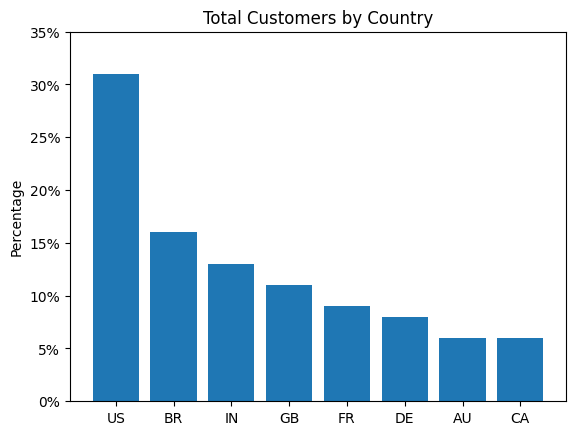

In [5]:
total_customer_by_country = df['country_code'].value_counts(normalize=True)

fig, ax = plt.subplots()
ax.bar(total_customer_by_country.index, total_customer_by_country.values * 100)
ax.set_title('Total Customers by Country')
ax.set_ylabel('Percentage')
y_ticks = ax.get_yticks()
y_formatted = [f'{value:.0f}%' for value in y_ticks]
ax.set_yticks(y_ticks, y_formatted)

plt.show()

In [6]:
total_customer_by_country

country_code
US    0.31
BR    0.16
IN    0.13
GB    0.11
FR    0.09
DE    0.08
AU    0.06
CA    0.06
Name: proportion, dtype: float64

# Risk profile geographic analysis

In [ ]:
risk_per_country = (
    df.groupby(['country_code', 'risk_profile'])
    .size()
    .reset_index(name='count')
)

risk_per_country

,country_code,risk_profile,count
0,AU,aggressive,3
1,AU,moderate,3
2,BR,aggressive,7
3,BR,conservative,3
4,BR,moderate,6
5,CA,aggressive,2
6,CA,conservative,1
7,CA,moderate,3
8,DE,aggressive,3
9,DE,conservative,3


In [73]:
pivot = risk_per_country.pivot(
    index='country_code',
    columns='risk_profile',
    values='count'
).fillna(0)

pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
pivot

risk_profile,aggressive,conservative,moderate
country_code,,,
US,8.0,7.0,16.0
BR,7.0,3.0,6.0
IN,7.0,2.0,4.0
GB,2.0,2.0,7.0
FR,2.0,5.0,2.0
DE,3.0,3.0,2.0
CA,2.0,1.0,3.0
AU,3.0,0.0,3.0


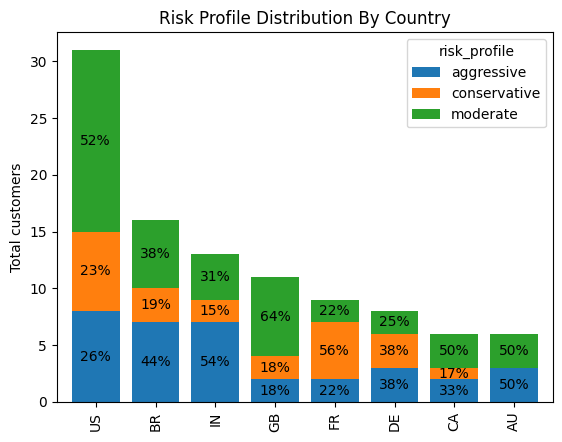

In [85]:
totals = pivot.sum(axis=1).sort_values(ascending=False)

ax = pivot.plot(kind='bar', stacked=True, width=.8)

for container in ax.containers:
    labels = []
    for bar, total in zip(container, totals):
        height = bar.get_height()
        if height == 0:
            labels.append('')
        else:
            pct = height / total * 100
            labels.append(f'{pct:.0f}%')

    ax.bar_label(container, labels=labels, label_type='center')

ax.set_title('Risk Profile Distribution By Country')
ax.set_ylabel('Total customers')
ax.set_xlabel('')
plt.show()

# Exploring the US due to the majority of customers

In [11]:
us_ct = df[df['country_code'] == 'US']

## US age distribution

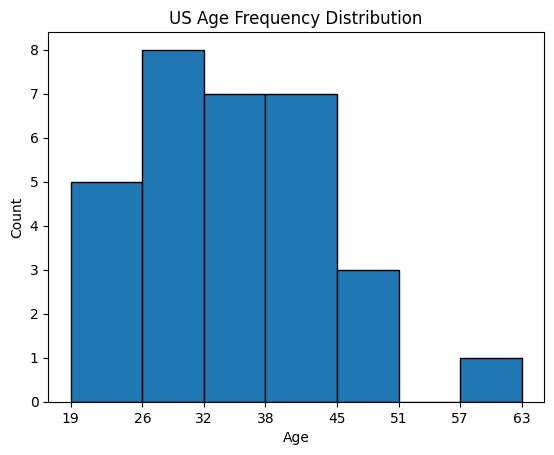

In [12]:
bins = np.ceil(np.histogram_bin_edges(us_ct['age'], bins='fd'))

fig, ax = plt.subplots()
ax.hist(us_ct['age'], edgecolor='black', bins=bins) 
ax.set_xticks(bins)
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.set_title('US Age Frequency Distribution')

plt.show()

In [13]:
us_ct['age'].describe()

count    31.000000
mean     34.096774
std       9.374984
min      19.000000
25%      27.500000
50%      35.000000
75%      38.000000
max      63.000000
Name: age, dtype: float64

In [14]:
us_ct['age'].quantile(.9)

np.float64(45.0)

# US risk profile analysis

In [15]:
us_ct['risk_profile'].value_counts(normalize=True)

risk_profile
moderate        0.516129
aggressive      0.258065
conservative    0.225806
Name: proportion, dtype: float64

In [16]:
us_ct[['risk_profile', 'age']].groupby('risk_profile').agg({
    'age': ['std', 'mean', 'median', 'min', 'max', 'count'],
})

age                                    
                    std       mean median   min   max count
risk_profile                                               
aggressive     9.372262  29.125000   25.0  21.0  47.0     8
conservative  13.352367  37.428571   36.0  19.0  63.0     7
moderate       6.631993  35.125000   36.0  26.0  49.0    16

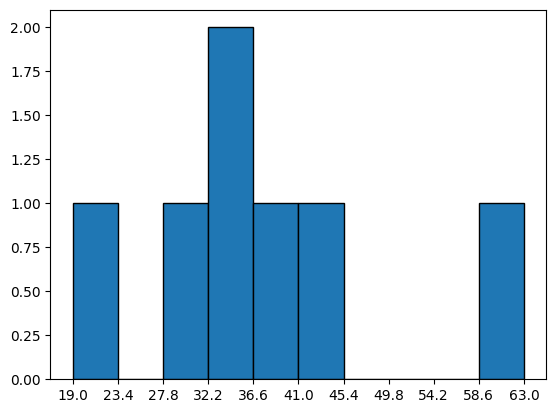

In [17]:
us_conservatives = us_ct[us_ct['risk_profile'] == 'conservative']
bins = np.histogram_bin_edges(us_conservatives['age'], bins=10)

fig, ax = plt.subplots()
ax.hist(us_conservatives['age'], edgecolor='black', bins=bins)
ax.set_xticks(bins)

plt.show()

In [18]:
us_conservatives['age'].describe()

count     7.000000
mean     37.428571
std      13.352367
min      19.000000
25%      32.500000
50%      36.000000
75%      39.500000
max      63.000000
Name: age, dtype: float64

In [19]:
df[['country_code', 'risk_profile']].groupby(by='country_code', as_index=False).value_counts()

,country_code,risk_profile,count
0,AU,aggressive,3
1,AU,moderate,3
2,BR,aggressive,7
3,BR,moderate,6
4,BR,conservative,3
5,CA,moderate,3
6,CA,aggressive,2
7,CA,conservative,1
8,DE,aggressive,3
9,DE,conservative,3


In [20]:
df['risk_profile'].value_counts()

risk_profile
moderate        43
aggressive      34
conservative    23
Name: count, dtype: int64

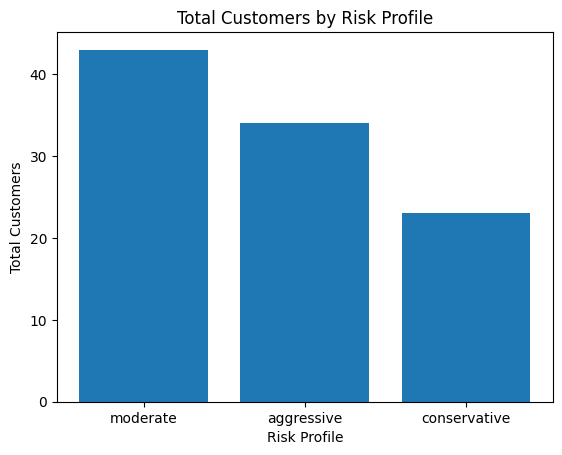

In [21]:
total_risk_profiles = df['risk_profile'].value_counts()

fig, ax = plt.subplots()
ax.bar(total_risk_profiles.index, total_risk_profiles.values)
ax.set_title('Total Customers by Risk Profile')
ax.set_xlabel('Risk Profile')
ax.set_ylabel('Total Customers')

plt.show()

# Age Distribution
Age impacts risk tolerance, product suitability, and regulatory constraints.

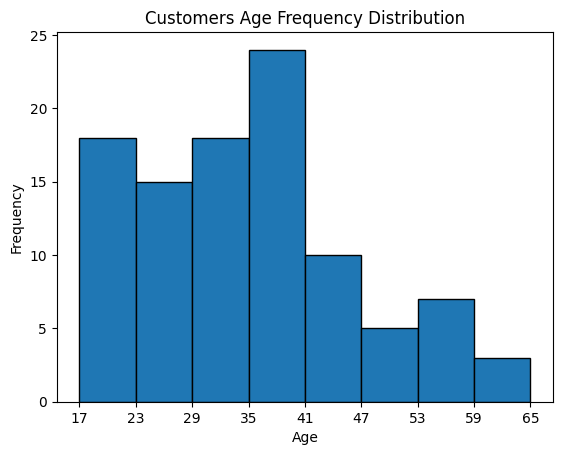

In [22]:
bins = np.histogram_bin_edges(df['age'], bins='fd')

fig, ax = plt.subplots()
ax.hist(df['age'], bins=bins, edgecolor='black')
ax.set_xticks(bins)
ax.set_title('Customers Age Frequency Distribution')
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')

plt.show()

In [23]:
df['age'].describe()

count    100.00000
mean      34.79000
std       11.43828
min       17.00000
25%       26.00000
50%       34.00000
75%       40.25000
max       65.00000
Name: age, dtype: float64

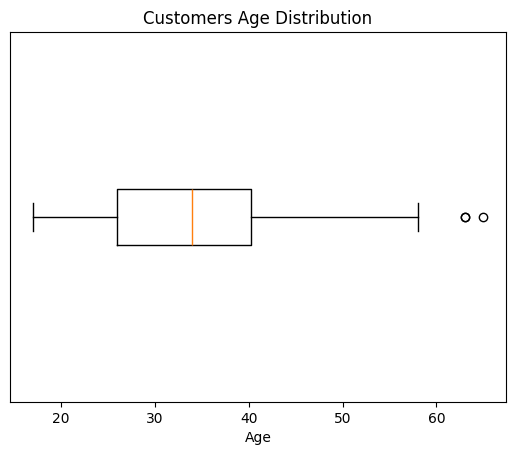

In [24]:
fig, ax = plt.subplots()
ax.boxplot(df['age'], orientation='horizontal')
ax.set_yticks([])
ax.set_xlabel('Age')
ax.set_title('Customers Age Distribution')

plt.show()